# Basics of Python for Neuroimagers
Shawn Rhoads, Georgetown University

This tutorial has been adapted from the following resources on Jupyter Notebooks and Python:
- Luke Chang's [DartBrains](https://dartbrains.org)

In [1]:
#!pip install update --user nibabel bids nilearn nltools

In [2]:
import numpy as np
import pandas as pd
import bids, os
import nibabel as nib
import matplotlib.pyplot as plt

# from matplotlib import transforms
from glob import glob
from nltools.data import Brain_Data
from nltools.mask import expand_mask, collapse_mask
from nilearn import image as img
from nilearn import plotting
from scipy import stats

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Nibabel

Neuroimaging data is often stored in the format of nifti files .nii which can also be compressed using gzip .nii.gz. These files store both 3D and 4D data and also contain structured metadata in the image header.

nibabel is an very nice tool to access nifti data stored on your file system in python. 

nibabel objects can be initialized by simply pointing to a nifti file even if it is compressed through gzip. I’m also including a path to where the data file is located so that I don’t have to constantly type this.

In [3]:
func_dir = '.\\example_epi_data'
template_dir = '.\\templates'

In [4]:
mni_file = nib.load(os.path.join(template_dir, 'MNI152_T1_2009c.nii'))

In [5]:
mni_data = mni_file.get_data()

In [6]:
header = mni_file.header
print(header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 193 229 193   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : mni
sform_code      : mni
quatern_b       : 0.0
quatern_c       : -0.0
quatern_d       : 0.0
qoffset_x       : -96.0
qoffset_y       : -132.0
qoffset_z       : -78.0
srow_x          : [  1.  -0.  -0. -96.]
srow_y          :

In [7]:
mni_data.shape

(193, 229, 193)

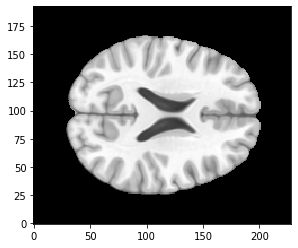

In [8]:
plt.imshow(mni_data[:,:,100],
           cmap="gray", 
           origin="lower") #axial slice

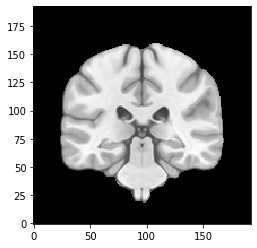

In [9]:
plt.imshow(mni_data[:,100,:].T,
           cmap="gray", 
           origin="lower") #coronal slice

We can also access data from the image header. Let’s assign the header of an image to a variable and print it to view it’s contents.

In [10]:
mni_header = mni_file.header
print(mni_header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 193 229 193   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : mni
sform_code      : mni
quatern_b       : 0.0
quatern_c       : -0.0
quatern_d       : 0.0
qoffset_x       : -96.0
qoffset_y       : -132.0
qoffset_z       : -78.0
srow_x          : [  1.  -0.  -0. -96.]
srow_y          :

Some of the important information in the header is information about the orientation of the image in space. This can be represented as the affine matrix.

The affine matrix is a way to transform images between spaces.

Applying different affine transformations allows us to rotate, reflect, scale, and shear the image.

In [11]:
mni_file.affine

array([[   1.,   -0.,   -0.,  -96.],
       [  -0.,    1.,   -0., -132.],
       [   0.,    0.,    1.,  -78.],
       [   0.,    0.,    0.,    1.]])

## Nilearn

Helpful plotting function from the `nilearn.plotting` module:
- `plotting.view_img`
- `plotting.glass_brain`
- `plotting.plot_anat`
- `plotting.plot_epi`

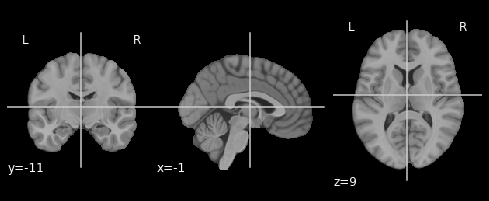

In [12]:
plotting.plot_anat(mni_file)

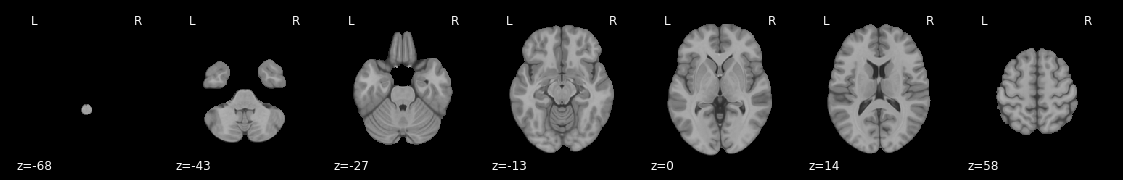

In [13]:
plotting.plot_anat(mni_file,
                   draw_cross=False, 
                   display_mode='z')

## nltools + pyBIDS

threshold is ignored for simple axial plots


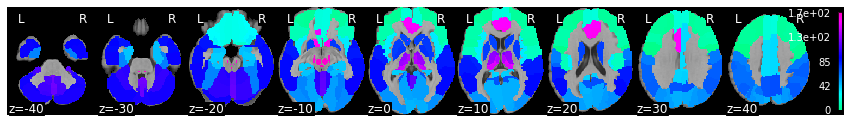

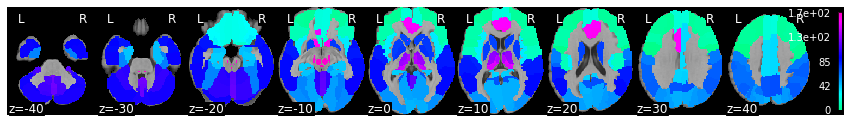

In [14]:
atlas_filename = os.path.join(template_dir, 'AAL3.nii')
AAL3 = Brain_Data(atlas_filename)
AAL3.plot(anatomical=mni_file, cmap='gist_rainbow')

In [15]:
AAL3

nltools.data.brain_data.Brain_Data(data=(238955,), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])

Notice we have one volume with 238955 voxels. 

We can break up this parcellation into separate volumes:

In [16]:
AAL3_x = expand_mask(AAL3)
AAL3_x

nltools.data.brain_data.Brain_Data(data=(166, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])

Cool, now we have 166 parcels

But, I'm really interested in the amygdala.

In [17]:
AAL3_x[44:46]

nltools.data.brain_data.Brain_Data(data=(2, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])

In [18]:
bilat_amyg = collapse_mask(AAL3_x[44:46], auto_label=False)
bilat_amyg.iplot(anatomical=mni_file)

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

Let's save our new amygdala parcel

In [19]:
bilat_amyg.write(file_name=".\\templates\\bilat_amyg.nii.gz")

## EPI data

In [20]:
# getting filenames with glob
func_filenames = glob(os.path.join(func_dir,"sub*\\func\\*bold.nii.gz"))
func_filenames

['.\\example_epi_data\\sub-0010042\\func\\sub-0010042_task-rest_space-MNI152NLin2009cSym_desc-preproc_bold.nii.gz',
 '.\\example_epi_data\\sub-0010064\\func\\sub-0010064_task-rest_space-MNI152NLin2009cSym_desc-preproc_bold.nii.gz']

In [21]:
# What does BIDSLayout do?
bids.BIDSLayout?

In [22]:
func_dir

'.\\example_epi_data'

In [23]:
# query with pybids
bids_layout = bids.BIDSLayout('.\\example_epi_data\\')
bids_layout

BIDS Layout: ...-Neuroimagers\example_epi_data | Subjects: 2 | Sessions: 0 | Runs: 0

In [24]:
sub_ids = bids_layout.get_subjects()
sub_ids

['0010042', '0010064']

In [25]:
task_ids = bids_layout.get_tasks()
task_ids

['rest']

In [26]:
bids_df = bids_layout.as_data_frame()
bids_df

,path,modality,subject,task,type
0,C:\Users\sr1209\Box Sync\Georgetown University...,NaN,NaN,NaN,description
1,C:\Users\sr1209\Box Sync\Georgetown University...,func,0010042,rest,regressors
2,C:\Users\sr1209\Box Sync\Georgetown University...,func,0010042,rest,bold
3,C:\Users\sr1209\Box Sync\Georgetown University...,func,0010064,rest,regressors
4,C:\Users\sr1209\Box Sync\Georgetown University...,func,0010064,rest,bold


In [27]:
func_files = bids_layout.get(return_type='file', type='bold', extensions='nii.gz')
func_files

['C:\\Users\\sr1209\\Box Sync\\Georgetown University\\MethLab\\Intro-Python-for-Neuroimagers\\example_epi_data\\sub-0010042\\func\\sub-0010042_task-rest_space-MNI152NLin2009cSym_desc-preproc_bold.nii.gz',
 'C:\\Users\\sr1209\\Box Sync\\Georgetown University\\MethLab\\Intro-Python-for-Neuroimagers\\example_epi_data\\sub-0010064\\func\\sub-0010064_task-rest_space-MNI152NLin2009cSym_desc-preproc_bold.nii.gz']

### Load the data!
two subjects from the [ADHD 1000 Functional Connectomes Project](http://fcon_1000.projects.nitrc.org/)

In [28]:
rest_epi = [Brain_Data(file) for file in func_filenames]

In [29]:
rest_brain_data = Brain_Data(func_filenames)

In [30]:
rest_epi[0]

nltools.data.brain_data.Brain_Data(data=(176, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])

Now, we have two subjects' resting-state data (176 TRs each) in a list. Let's plot the first subject.

In [31]:
rest_epi[0].iplot(anatomical=mni_file)

interactive(children=(FloatText(value=0.0, description='Threshold'), IntSlider(value=0, continuous_update=Fals…

Cool, now let's mask the data with our bilateral amygdala parcel

In [32]:
rest_epi_amyg = []
for sub in rest_epi: #loop over subjects
    curSub = sub.apply_mask(bilat_amyg)
    rest_epi_amyg.append(curSub)

We can plot one subject on the MNI template to see how nice the mask looks!

In [33]:
rest_epi_amyg[0].iplot(anatomical=mni_file)

interactive(children=(FloatText(value=0.0, description='Threshold'), IntSlider(value=0, continuous_update=Fals…

We have 176 volumes (for each TR) that contain 468 voxels for each subject.

In [34]:
rest_epi_amyg[0]

nltools.data.brain_data.Brain_Data(data=(176, 468), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])

We can also just plot the mean timeseries for each subject:

Let's create a dictionary where keys are subjects and values are lists of amygdala timeseries:

In [35]:
amyg_ts = {}
for index, subject in enumerate(rest_epi_amyg):
    amyg_ts[index] = [np.mean(TR) for TR in subject.data]
    amyg_ts[index] = stats.zscore(amyg_ts[index])

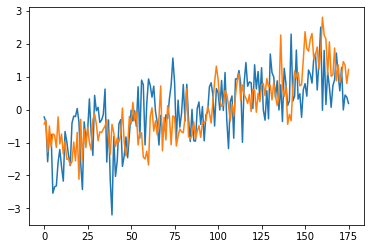

In [36]:
# let's plot:
for subj in range(0,len(amyg_ts)):
    plt.plot(amyg_ts[subj])

What about right FFG?

In [37]:
r_ffg = AAL3_x[59]

threshold is ignored for simple axial plots


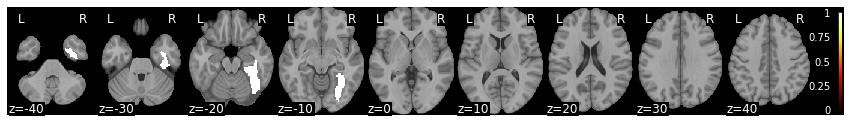

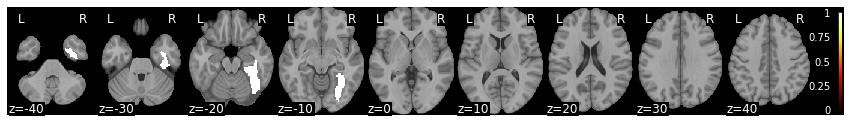

In [38]:
r_ffg.plot(anatomical=mni_file)

In [39]:
rest_epi_rFFG = []
for sub in rest_epi: #loop over subjects
    curSub = sub.apply_mask(r_ffg)
    rest_epi_rFFG.append(curSub)

In [40]:
rest_epi_rFFG[0].iplot(anatomical=mni_file)

interactive(children=(FloatText(value=0.0, description='Threshold'), IntSlider(value=0, continuous_update=Fals…

In [41]:
# new dictionary with right FFG timeseries data (not denoised yet)
rffg_ts = {}
for index, subject in enumerate(rest_epi_rFFG):
    rffg_ts[index] = [np.mean(TR) for TR in subject.data]
    rffg_ts[index] = stats.zscore(rffg_ts[index])

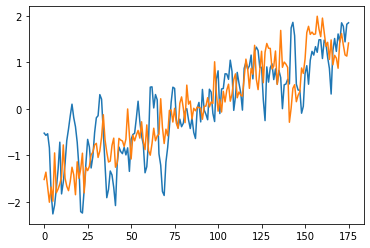

In [42]:
for subj in range(0,len(rffg_ts)):
    plt.plot(rffg_ts[subj])

We can conduct a first-pass "functional connectivity" analysis at the first level to see how well amygdala and right FFG timeseries data align (within each subject)... remember, we have not yet denoised these data!

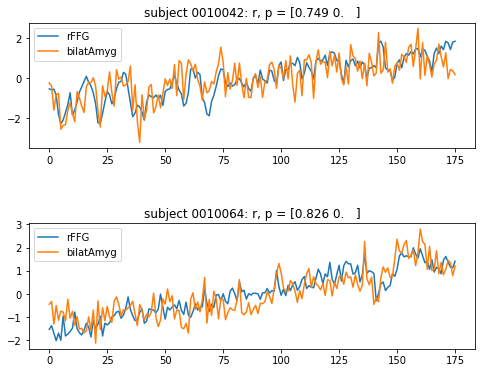

In [43]:
from scipy.stats import pearsonr

fig = plt.figure()
fig.subplots_adjust(hspace=0.6, wspace=0.6)
fig.set_figwidth(8)
fig.set_figheight(6)

for index, subID in enumerate(sub_ids):
    plt.subplot(2, 1, index+1)
    plt.plot(rffg_ts[index], label=f"rFFG")
    plt.plot(amyg_ts[index], label=f"bilatAmyg")
    plt.title(f"subject {subID}: r, p = {np.around(pearsonr(amyg_ts[index], rffg_ts[index]), 3)}")
    plt.legend()

Suprisingly, right FFG aligns with bilateral amygdala timeseries pretty well across these two subjects on non-denoised resting-state data! haha